### ----------------- Classification -----------------

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.multioutput import MultiOutputClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

### Data Cleaning

In [242]:
df = pd.read_csv(r"C:\Users\alandlos\Downloads\DEPI_FINALE\DEPI_FINALE\clinically_validated_balanced_disease_data.csv")

print(df.info())

# Remove duplicates
duplicate_count = df.duplicated().sum()
print(f"Found {duplicate_count} duplicate rows.")
df.drop_duplicates(inplace=True)

# Label encoding
gender_mapping = {'Men': 0, 'Women': 1, 'Children': 2}
df['Gender'] = df['Gender'].map(gender_mapping)

protein_glucose_mapping = {'Absent': 0, 'Trace': 1}
df['Urine Protein'] = df['Urine Protein'].map(protein_glucose_mapping)
df['Urine Glucose'] = df['Urine Glucose'].map(protein_glucose_mapping)

# Remove nulls
df.fillna(df.median(numeric_only=True), inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 36 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Gender                                            30000 non-null  object 
 1   Age                                               30000 non-null  int64  
 2   Hemoglobin (g/dL)                                 30000 non-null  float64
 3   RBC (million/µL)                                  30000 non-null  float64
 4   Platelet Count (platelets/µL)                     30000 non-null  float64
 5   Fasting Blood Sugar (mg/dL)                       30000 non-null  float64
 6   Hemoglobin A1C (%)                                30000 non-null  float64
 7   Serum Creatinine (mg/dL)                          30000 non-null  float64
 8   Blood Urea Nitrogen (BUN) (mg/dL)                 30000 non-null  float64
 9   Glomerular Filtra

### Splitting Data (Early Splitting to avoid data Leakage)

In [245]:
target_columns = ['Diabetes', 'Anemia', 'Kidney Failure', 'Liver Failure', 'Ischimic Heart Disease']
X = df.drop(columns=target_columns)
y = df[target_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Handeling Outliers

In [247]:
for col in X_train.columns:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_train[col] = np.clip(X_train[col], lower_bound, upper_bound)
    X_test[col] = np.clip(X_test[col], lower_bound, upper_bound)



### Feature Selection

In [249]:
mi_scores = pd.DataFrame({target: mutual_info_classif(X_train, y_train[target], discrete_features=False) for target in target_columns}, index=X_train.columns)
mi_scores["Average_Score"] = mi_scores.mean(axis=1)
selected_features = mi_scores[mi_scores["Average_Score"] >= 0.001].index.tolist()
X_train = X_train[selected_features]
X_test = X_test[selected_features]


### Feature Scaling

In [251]:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=selected_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=selected_features)


In [252]:
X_train = X_train_scaled
X_test = X_test_scaled

### Model Building

### XGBoost

In [255]:
from sklearn.model_selection import GridSearchCV


In [256]:
# Define the base XGBoost model
base_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Wrap in MultiOutputClassifier
multi_model = MultiOutputClassifier(base_model)

# Define parameter grid
param_grid = {
    'estimator__n_estimators': [50, 100],
    'estimator__learning_rate': [0.05, 0.1],
    'estimator__max_depth': [3, 5]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    multi_model,
    param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit to training data
grid_search.fit(X_train_scaled, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\alandlos\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:57:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\alandlos\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:57:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\alandlos\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:57:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.w

Best Parameters: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 100}
Best CV Accuracy: 0.9111250000000001


### Model Evaluation

In [258]:
# Already trained best model
best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train_scaled)
training_accuracy = accuracy_score(y_train, y_train_pred)
print("XGBoost Train Accuracy:", training_accuracy)

y_pred = best_model.predict(X_test_scaled)
print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrices
cm = multilabel_confusion_matrix(y_test, y_pred)
for i, label in enumerate(target_columns):
    print(f"Confusion matrix for {label}:")
    print(cm[i])

XGBoost Train Accuracy: 0.9483333333333334
XGBoost Test Accuracy: 0.9196666666666666
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3366
           1       0.99      0.96      0.97      3117
           2       0.98      0.93      0.95      2694
           3       0.99      0.98      0.99      1832
           4       1.00      1.00      1.00      3544

   micro avg       0.99      0.97      0.98     14553
   macro avg       0.99      0.97      0.98     14553
weighted avg       0.99      0.97      0.98     14553
 samples avg       0.95      0.94      0.94     14553

Confusion matrix for Diabetes:
[[2633    1]
 [   7 3359]]
Confusion matrix for Anemia:
[[2841   42]
 [ 137 2980]]
Confusion matrix for Kidney Failure:
[[3247   59]
 [ 182 2512]]
Confusion matrix for Liver Failure:
[[4156   12]
 [  35 1797]]
Confusion matrix for Ischimic Heart Disease:
[[2452    4]
 [   9 3535]]


C:\Users\alandlos\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alandlos\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alandlos\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

### Neural Network

In [260]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),  
    
    Dense(96, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    
    # Output layer for 5 classes (multi-label classification)
    Dense(5, activation='sigmoid')  
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),  
    loss='binary_crossentropy',  
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,  
    restore_best_weights=True,
    min_delta=0.001  # Minimum change to qualify as improvement
)

# Train Model with larger batch size
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,  
    batch_size=64,  
    callbacks=[early_stop],
    verbose=1
)

# Threshold predictions at 0.5 for multi-label classification
y_pred_train = (model.predict(X_train) > 0.5).astype(int)
y_pred_test = (model.predict(X_test) > 0.5).astype(int)

C:\Users\alandlos\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.6906 - val_loss: 0.4359
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.4310 - val_loss: 0.2889
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.3575 - val_loss: 0.2505
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.3229 - val_loss: 0.2342
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.3008 - val_loss: 0.2238
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.2917 - val_loss: 0.2168
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2785 - val_loss: 0.2106
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.2707 - val_loss: 0.2051
Epoch 9/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.2647 - val_loss: 0.2001
Epoch 10/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2592 - val_loss: 0.1952
Epoch 11/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.2507 - val_loss: 0.1930
Epoch 12/100
300/300 ━━━━━━━━

### Evaluation

In [262]:
# Convert predictions and true labels to numpy arrays if they aren't already
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test
y_pred_test_np = y_pred_test.values if hasattr(y_pred_test, 'values') else y_pred_test

# Evaluation metrics for each condition
conditions = ['Diabetes', 'Anemia', 'Kidney Failure', 'Liver Failure', 'Ischemic Heart Disease']

print("\nOverall Accuracy Scores:")
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test_np, y_pred_test_np))

print("\nPer-Condition Classification Reports:")
for i, condition in enumerate(conditions):
    print(f"\n{condition}:")
    print(classification_report(y_test_np[:, i], y_pred_test_np[:, i]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_np[:, i], y_pred_test_np[:, i]))


Overall Accuracy Scores:
Train Accuracy: 0.8217916666666667
Test Accuracy: 0.7955

Per-Condition Classification Reports:

Diabetes:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2634
           1       1.00      1.00      1.00      3366

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Confusion Matrix:
[[2632    2]
 [  11 3355]]

Anemia:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2883
           1       0.92      0.92      0.92      3117

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000

Confusion Matrix:
[[2633  250]
 [ 250 2867]]

Kidney Failure:
              precision    recall  f1-score   support

           0       0.95      0.93      0.9

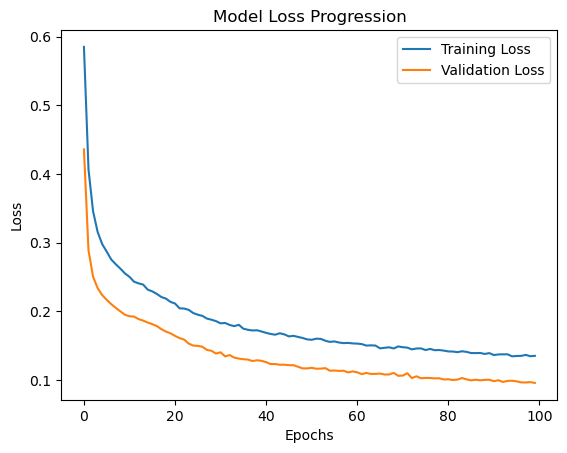

In [263]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss Progression")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Model Comparsion

C:\Users\alandlos\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alandlos\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alandlos\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

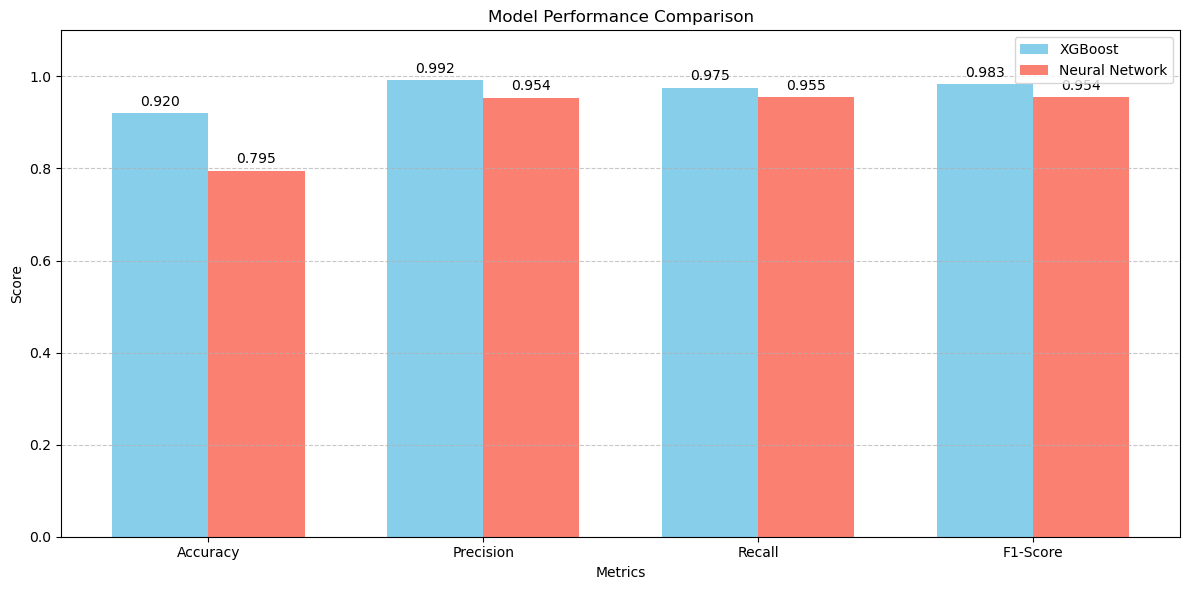

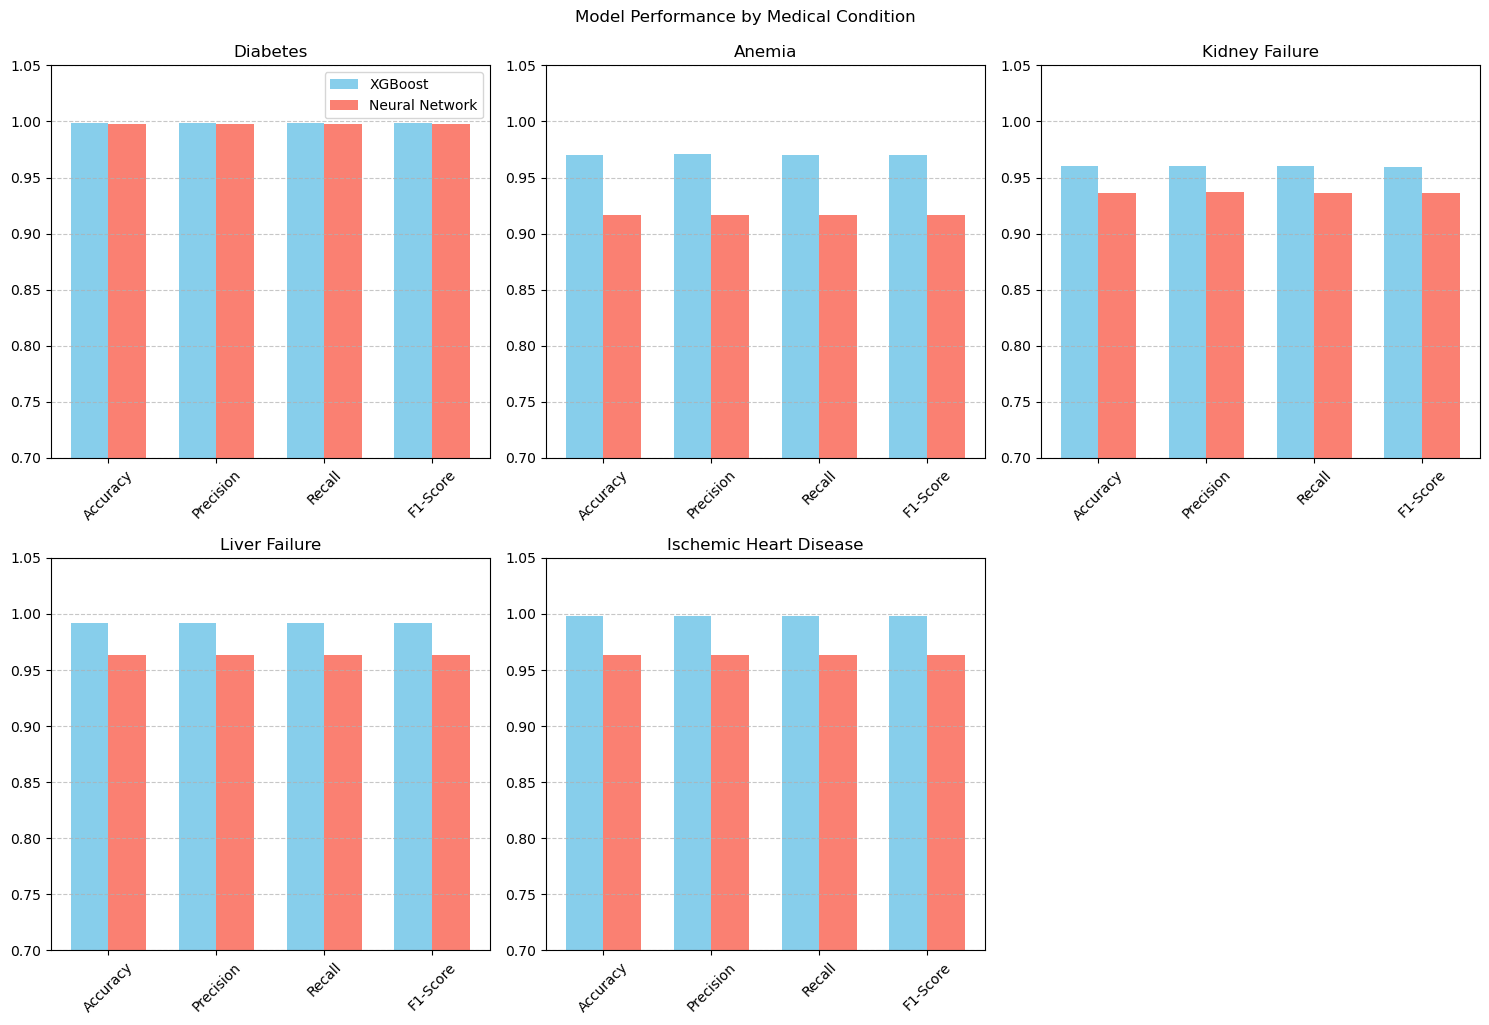

In [265]:
# Prepare the data
model_names = ['XGBoost', 'Neural Network']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Calculate metrics for XGBoost (from your code)
xgboost_report = classification_report(y_test, y_pred, output_dict=True)
xgboost_metrics = [
    accuracy_score(y_test, y_pred),
    xgboost_report['weighted avg']['precision'],
    xgboost_report['weighted avg']['recall'],
    xgboost_report['weighted avg']['f1-score']
]

# Calculate metrics for Neural Network (from your code)
nn_report = classification_report(y_test_np, y_pred_test_np, output_dict=True)
nn_metrics = [
    accuracy_score(y_test_np, y_pred_test_np),
    nn_report['weighted avg']['precision'],
    nn_report['weighted avg']['recall'],
    nn_report['weighted avg']['f1-score']
]

# Create the comparison plot
plt.figure(figsize=(12, 6))
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, xgboost_metrics, width, label='XGBoost', color='skyblue')
plt.bar(x + width/2, nn_metrics, width, label='Neural Network', color='salmon')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for i in range(len(metrics)):
    plt.text(i - width/2, xgboost_metrics[i] + 0.01, f'{xgboost_metrics[i]:.3f}', 
             ha='center', va='bottom')
    plt.text(i + width/2, nn_metrics[i] + 0.01, f'{nn_metrics[i]:.3f}', 
             ha='center', va='bottom')

plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

# Condition-specific comparison
conditions = ['Diabetes', 'Anemia', 'Kidney Failure', 'Liver Failure', 'Ischemic Heart Disease']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

plt.figure(figsize=(15, 10))
for i, condition in enumerate(conditions):
    # Get XGBoost metrics for this condition
    xg_cond_report = classification_report(y_test.iloc[:, i], y_pred[:, i], output_dict=True)
    xg_cond_metrics = [
        accuracy_score(y_test.iloc[:, i], y_pred[:, i]),
        xg_cond_report['weighted avg']['precision'],
        xg_cond_report['weighted avg']['recall'],
        xg_cond_report['weighted avg']['f1-score']
    ]
    
    # Get Neural Network metrics for this condition
    nn_cond_report = classification_report(y_test_np[:, i], y_pred_test_np[:, i], output_dict=True)
    nn_cond_metrics = [
        accuracy_score(y_test_np[:, i], y_pred_test_np[:, i]),
        nn_cond_report['weighted avg']['precision'],
        nn_cond_report['weighted avg']['recall'],
        nn_cond_report['weighted avg']['f1-score']
    ]
    
    plt.subplot(2, 3, i+1)
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, xg_cond_metrics, width, label='XGBoost', color='skyblue')
    plt.bar(x + width/2, nn_cond_metrics, width, label='Neural Network', color='salmon')
    
    plt.title(condition)
    plt.xticks(x, metrics, rotation=45)
    plt.ylim(0.7, 1.05)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.suptitle('Model Performance by Medical Condition', y=1.02)
plt.show()

### ---------------- Progression ----------------

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBRegressor, XGBClassifier

### Anemia_progression

### DataSet After Cleaning

In [454]:
df=pd.read_csv(r"C:\Users\alandlos\Downloads\cleaned_tests_Anemia.csv")
df

,Age,Gender,Total Iron Binding Capacity (TIBC),Vitamin B12,Folate,Reticulocyte Count,Disease Progression (%)
0,63,0.0,184.538560,399.943929,12.174786,1.136983,33.216055
1,71,0.0,283.607771,760.550179,13.697754,1.449537,0.000000
2,20,1.0,162.391643,509.174260,13.037187,1.280177,31.750662
3,52,1.0,353.454434,258.949108,19.753214,1.166407,0.000000
4,3,1.0,314.710188,106.803458,16.191672,0.889215,31.434434
...,...,...,...,...,...,...,...
19995,66,1.0,181.109632,1763.365806,16.058368,0.781277,67.849886
19996,37,1.0,215.161992,1916.273198,12.025495,2.341326,66.594293
19997,11,1.0,407.674269,301.071528,13.440416,1.550284,0.000000
19998,29,0.0,321.314265,838.208114,4.644623,1.012215,0.000000


### Train test Split

In [445]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Min-Max Scaling

In [448]:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### Model Building

In [451]:
threshold = 0.55
y_anemia = np.where(y >= threshold, 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y_anemia, test_size=0.3, random_state=42)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

models = {
    "Logistic Regression": LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
}

for name, model in models.items():
    print(f"\n===== {name} Anemia =====")
    model.fit(X_train_scaled, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train_scaled))
    test_acc = accuracy_score(y_test, model.predict(X_test_scaled))
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, model.predict(X_test_scaled)))



===== Logistic Regression Anemia =====
Train Accuracy: 0.7953
Test Accuracy: 0.7948
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.88      0.72      1823
           1       0.94      0.76      0.84      4177

    accuracy                           0.79      6000
   macro avg       0.77      0.82      0.78      6000
weighted avg       0.84      0.79      0.80      6000


===== Decision Tree Anemia =====
Train Accuracy: 1.0000
Test Accuracy: 0.8948
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.82      1823
           1       0.92      0.93      0.92      4177

    accuracy                           0.89      6000
   macro avg       0.88      0.87      0.87      6000
weighted avg       0.89      0.89      0.89      6000


===== KNN Anemia =====
Train Accuracy: 0.9114
Test Accuracy: 0.8778
Classification Report:
               precision    recall  f1-sco

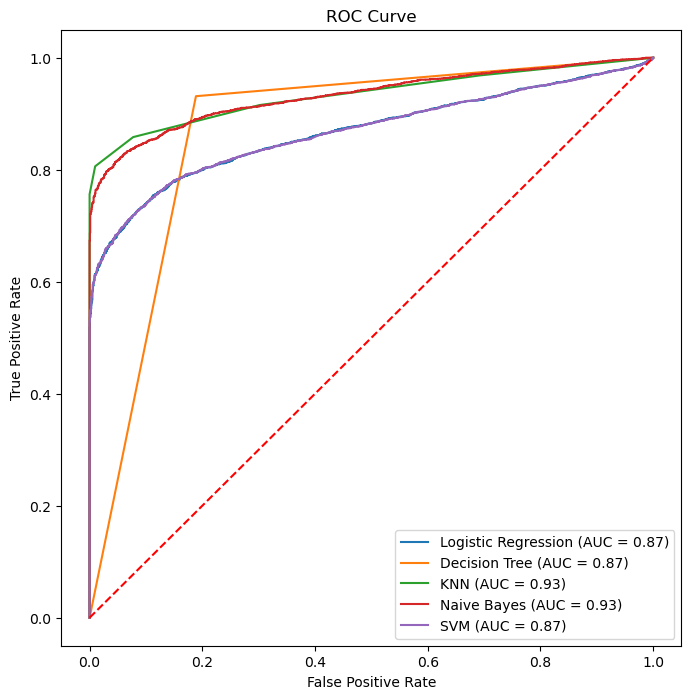

In [452]:
plt.figure(figsize=(8, 8))
for name, model in models.items():
    try:
        y_scores = model.predict_proba(X_test_scaled)[:, 1]
    except AttributeError:
        y_scores = model.decision_function(X_test_scaled)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


### Kidney_disease Progression

### DataSet After Cleaning

In [30]:
df = pd.read_csv(r"C:\Users\alandlos\Downloads\cleaned_tests(Kidney).csv")
df

,Age,Gender,24-hour Urine Protein,Serum Uric Acid,Serum Creatinine,Glomerular Filtration Rate (GFR),Blood Urea Nitrogen (BUN),Disease Progression (%)
0,66.0,0.0,507.204146,8.170552,8.115556,113.122486,40.832640,87.999238
1,69.0,1.0,110.549490,6.870588,1.197688,53.496338,19.743156,0.000000
2,65.0,0.0,493.188425,3.250824,4.169841,32.204347,26.305783,50.053152
3,9.0,1.0,49.044910,2.419114,0.621062,97.408962,16.694962,0.000000
4,44.0,1.0,2.013638,11.967031,4.583585,75.031437,23.267115,38.394260
...,...,...,...,...,...,...,...,...
19995,55.0,1.0,642.490275,3.278989,8.484720,107.620576,30.815843,61.211025
19996,74.0,0.0,313.682653,11.176939,3.997290,50.130855,29.173130,62.213117
19997,71.0,1.0,187.465716,5.817046,0.926323,61.189402,20.372254,0.000000
19998,21.0,1.0,130.737882,3.964210,0.766637,89.098488,14.599276,0.000000


### Train-Test Split

In [33]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Min_Max Scaling

In [36]:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### Model training ang Evaluation

### XGBoost Classification

In [40]:
threshold = 0.55
y_kidney = np.where(y >= threshold, 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y_kidney, test_size=0.3, random_state=42)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

models = {
    "Logistic Regression": LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
}

for name, model in models.items():
    print(f"\n===== {name} (kidney Diagnosis)=====")
    model.fit(X_train_scaled, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train_scaled))
    test_acc = accuracy_score(y_test, model.predict(X_test_scaled))
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, model.predict(X_test_scaled)))


===== Logistic Regression (kidney Diagnosis)=====
Train Accuracy: 0.9724
Test Accuracy: 0.9687
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      1823
           1       1.00      0.95      0.98      4177

    accuracy                           0.97      6000
   macro avg       0.95      0.98      0.96      6000
weighted avg       0.97      0.97      0.97      6000


===== Decision Tree (kidney Diagnosis)=====
Train Accuracy: 1.0000
Test Accuracy: 0.9993
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1823
           1       1.00      1.00      1.00      4177

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000


===== KNN (kidney Diagnosis)=====
Train Accuracy: 0.9942
Test Accuracy: 0.9915
Classification Report:
         

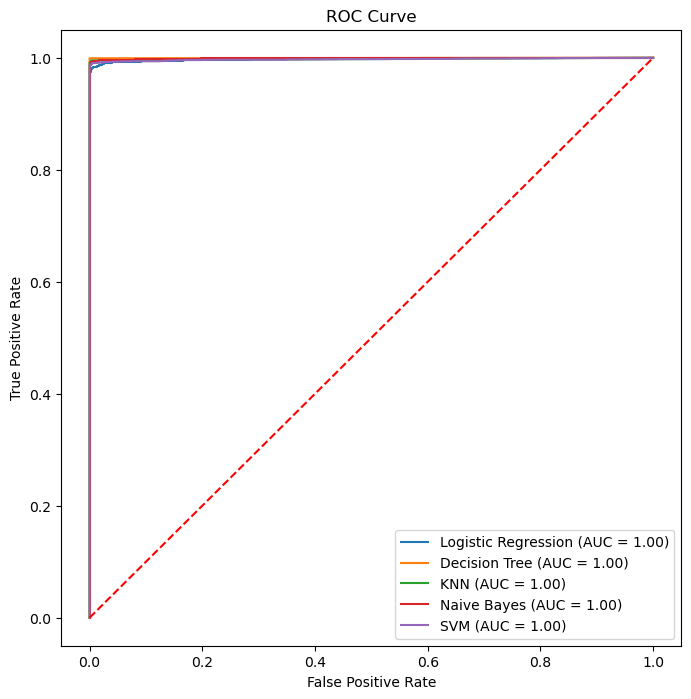

In [41]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

for name, model in models.items():
    y_scores = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test_scaled)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


### Liver_disease Progression

### DataSet After Cleaning

In [468]:
file_path = r"C:\Users\alandlos\Downloads\cleaned_tests(Liver).csv"
df = pd.read_csv(file_path)
df

,Gender,Age,PT_INR,GGT,Ammonia,Bilirubin,Albumin,Creatinine,ALT,AST,Platelet_Count,Disease Progression (%)
0,0.0,18.0,0.889264,18.850774,76.012720,2.654185,2.682807,0.601442,27.874777,26.998861,263740.438358,54.303570
1,0.0,77.0,1.150013,63.871106,40.555181,0.573885,4.726946,1.072835,53.363788,34.540932,197917.109522,0.000000
2,0.0,27.0,1.232707,9.299403,79.321141,2.319888,5.456347,1.494124,62.391436,29.767047,222204.097188,49.414277
3,0.0,77.0,1.057582,49.246811,27.891545,0.499402,4.204866,1.511349,51.184792,22.736257,289131.997808,0.000000
4,1.0,11.0,1.291213,74.103689,76.266678,2.503787,3.656453,1.426805,32.496023,22.028961,360078.922857,42.923540
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.0,18.0,1.428327,41.172591,45.033655,0.933465,2.875548,1.602203,43.421236,15.502692,121645.474365,62.269623
19996,1.0,28.0,1.673128,45.404922,16.908175,2.260033,3.911183,0.888240,55.054316,26.032329,211407.658333,55.845252
19997,0.0,75.0,1.272630,53.726775,46.384930,0.859229,4.241445,1.505820,31.887096,46.122031,273736.365309,0.000000
19998,1.0,25.0,0.985709,12.579627,24.357338,0.759827,4.308039,1.008551,35.413291,23.468732,183061.555130,0.000000


### Train-Test Split

In [471]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Min_Max Scaling

In [474]:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### Model training ang Evaluation

### XGBoost Classification

In [478]:
threshold = 0.55
y_liver = np.where(y >= threshold, 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y_liver, test_size=0.3, random_state=42)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

models = {
    "Logistic Regression": LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
}

for name, model in models.items():
    print(f"\n===== {name} Liver_disease =====")
    model.fit(X_train_scaled, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train_scaled))
    test_acc = accuracy_score(y_test, model.predict(X_test_scaled))
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, model.predict(X_test_scaled)))



===== Logistic Regression Liver_disease =====
Train Accuracy: 0.9119
Test Accuracy: 0.9127
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.87      1823
           1       0.98      0.89      0.93      4177

    accuracy                           0.91      6000
   macro avg       0.89      0.93      0.90      6000
weighted avg       0.92      0.91      0.91      6000


===== Decision Tree Liver_disease =====
Train Accuracy: 1.0000
Test Accuracy: 0.9908
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1823
           1       0.99      0.99      0.99      4177

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000


===== KNN Liver_disease =====
Train Accuracy: 0.9670
Test Accuracy: 0.9517
Classification Report:
               precis

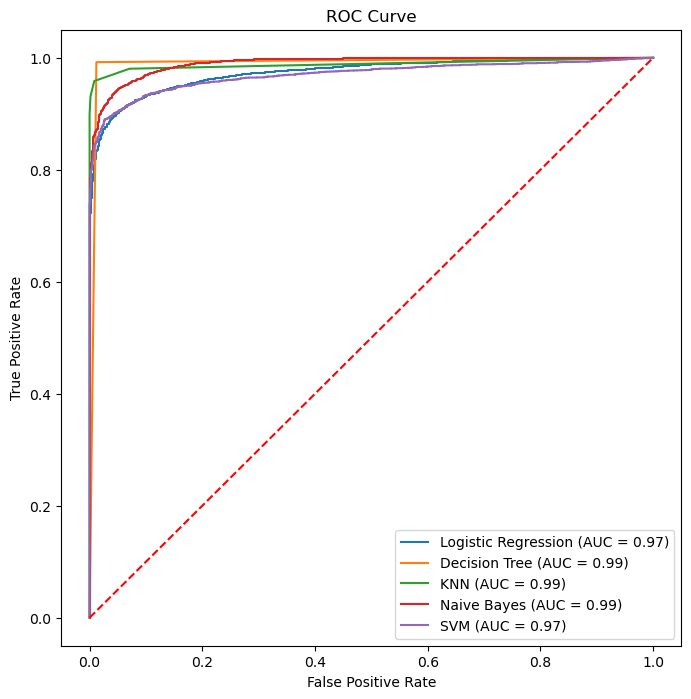

In [479]:
plt.figure(figsize=(8, 8))
for name, model in models.items():
    try:
        y_scores = model.predict_proba(X_test_scaled)[:, 1]
    except AttributeError:
        y_scores = model.decision_function(X_test_scaled)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Heart_disease

### DataSet After Cleaning

In [48]:
file_path = "cleaned_tests(Heart).csv"  
df = pd.read_csv(file_path)
df

,Age,Gender,LDL,HDL,Triglycerides,CRP,ECG,Blood Pressure,Cholesterol,Troponin,BNP,Ischimic Heart Disease Progression (%)
0,32.0,0.0,106.220454,70.744201,370.105934,4.491491,0.0,110.096149,372.827737,1.016352,496.572053,35.594104
1,51.0,0.0,161.783438,49.171371,151.060239,2.755058,0.0,106.196404,231.037047,0.202168,35.096488,0.000000
2,53.0,1.0,85.068998,69.237762,454.998727,7.616421,0.0,137.087659,300.988576,8.603462,1023.339041,47.430639
3,49.0,0.0,130.429228,84.702730,190.451413,2.441376,0.0,121.779674,177.334886,0.393178,31.042936,0.000000
4,85.0,1.0,82.469885,69.388153,241.794630,5.934630,0.0,102.870385,339.815102,6.606478,1881.219055,56.496240
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,84.0,0.0,120.644867,50.917801,461.513777,2.011617,0.0,116.898513,249.271113,4.307546,970.623963,62.864412
19996,60.0,0.0,62.702925,35.323836,373.233920,11.870751,0.0,97.581534,380.921689,7.871880,333.970447,48.381613
19997,56.0,1.0,132.388423,46.125522,127.765062,2.595820,0.0,116.902257,217.297981,0.219183,56.875183,0.000000
19998,34.0,1.0,110.105840,41.287120,101.157181,2.429583,0.0,134.864925,196.639648,0.182201,7.928339,0.000000


### Train-Test Split

In [19]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Min_Max Scaling

In [22]:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### Model training and Evaluation

### XGBoost Classification

In [26]:
threshold = 0.55
y_heart = np.where(y >= threshold, 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y_heart, test_size=0.3, random_state=42)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

models = {
    "Logistic Regression": LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
}

for name, model in models.items():
    print(f"\n===== {name} Liver_disease =====")
    model.fit(X_train_scaled, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train_scaled))
    test_acc = accuracy_score(y_test, model.predict(X_test_scaled))
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, model.predict(X_test_scaled)))



===== Logistic Regression Liver_disease =====
Train Accuracy: 0.9394
Test Accuracy: 0.9440
Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92      1860
           1       1.00      0.92      0.96      4140

    accuracy                           0.94      6000
   macro avg       0.92      0.96      0.94      6000
weighted avg       0.95      0.94      0.95      6000


===== Decision Tree Liver_disease =====
Train Accuracy: 1.0000
Test Accuracy: 0.9887
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1860
           1       0.99      0.99      0.99      4140

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000


===== KNN Liver_disease =====
Train Accuracy: 0.9895
Test Accuracy: 0.9883
Classification Report:
               precis

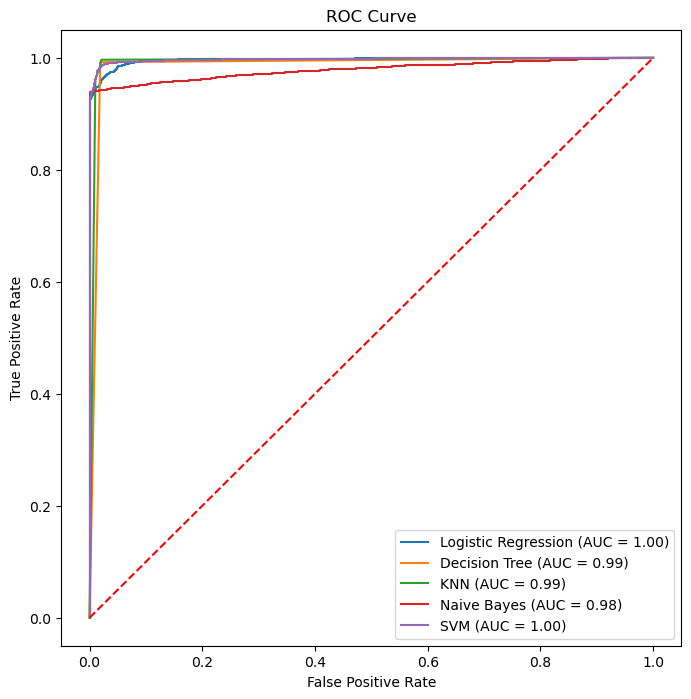

In [27]:
plt.figure(figsize=(8, 8))
for name, model in models.items():
    try:
        y_scores = model.predict_proba(X_test_scaled)[:, 1]
    except AttributeError:
        y_scores = model.decision_function(X_test_scaled)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
